# Installation and Environment Setup

In [5]:
# !pip install pandas numpy scikit-learn spacy wordcloud spacy textwrap3

In [3]:
import re, string
import spacy
import joblib
# import pika
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from textwrap import wrap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline

In [4]:
df = pd.read_csv("../data.dat", delimiter="\t", header=None, names=["target", "text"])

In [3]:
df.head()

,target,text
0,4,Catheterization laboratory events and hospital...
1,5,Renal abscess in children. Three cases of rena...
2,2,Hyperplastic polyps seen at sigmoidoscopy are ...
3,5,Subclavian artery to innominate vein fistula a...
4,4,Effect of local inhibition of gamma-aminobutyr...


In [4]:
df["target"].unique()

array([4, 5, 2, 1, 3])

In [5]:
df["target"].value_counts(normalize=True)

target
5    0.332802
1    0.219075
4    0.211317
3    0.133329
2    0.103477
Name: proportion, dtype: float64

In [6]:
len(df)

14438

# Clearning and Preprocessing

## Expand Contractions

In [9]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  # print (type(text))
  return [contractions_re.sub(replace, t) for t in text]

# Expanding Contractions in the reviews
# df['text']=df['text'].apply(lambda x:expand_contractions(x))
expTrans = FunctionTransformer(expand_contractions)

In [10]:
# # print (list(df["text"].values))
# def replace(match):
#     return contractions_dict[match.group(0)]
# print ([t for t in df["text"].tolist()[:5]])
# # print (df["text"].tolist()[0])
# expTrans.transform(df["text"].tolist()[:5])

## Lowercase the Reviews

In [11]:
# df['cleaned']=df['text'].apply(lambda x: x.lower())
def lowercase(text):
    return [t.lower() for t in text]
lowercaseTrans = FunctionTransformer(lowercase)

## Remove digits and words containing digits

In [12]:
# df['cleaned']=df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))
def removedigits(text):
    return [re.sub('\w*\d\w*','', t) for t in text]
removedigitsTrans = FunctionTransformer(removedigits)

## Remove Punctuations

In [13]:
# df['cleaned']=df['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
def removepunct(text):
    return [re.sub('[%s]' % re.escape(string.punctuation), '', t) for t in text]
removepunctTrans = FunctionTransformer(removepunct)

## Removing extra spaces

In [14]:
# df['cleaned']=df['cleaned'].apply(lambda x: re.sub(' +',' ',x))
def removespaces(text):
    return [re.sub(' +',' ',t) for t in text]
removespacesTrans = FunctionTransformer(removespaces)

In [15]:
# Visualize reviews after cleaning
for index,text in enumerate(df['cleaned'][35:40]):
  print('Review %d:\n'%(index+1),text)

KeyError: 'cleaned'

## Stopwords removeal and Lemmatization

In [31]:
# spacy.cli.download("en_core_web_sm")

In [16]:
# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])
# Lemmatization with stopwords removal
# df['lemmatized']=df['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))
def lemmatize(text):
    return [' '.join([token.lemma_ for token in list(nlp(t)) if (token.is_stop==False)]) for t in text] 
lemmaTrans = FunctionTransformer(lemmatize)

# EDA

## Generate wordcloud

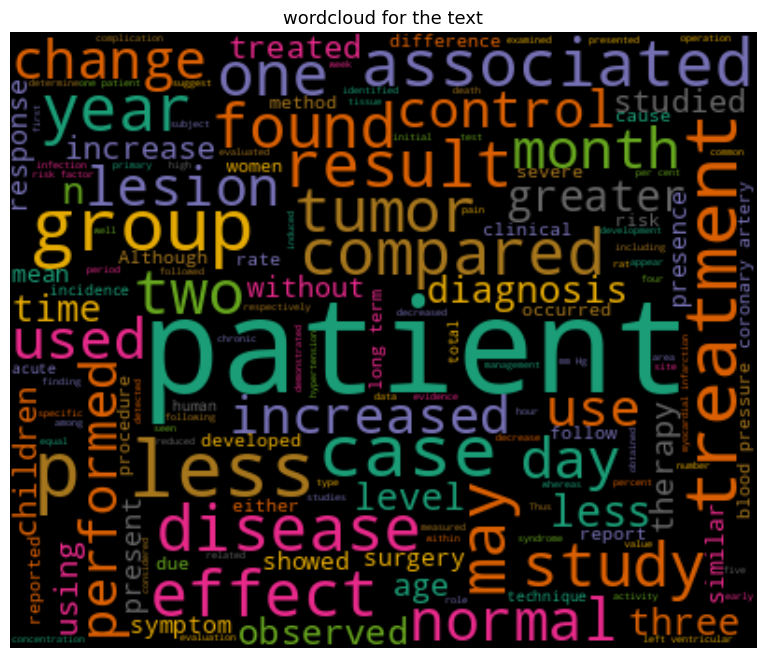

In [29]:
# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()

# combine text to generate wordcloud
text = " ".join(row for row in df["text"])

# Plotting word cloud for each product
# for index,product in enumerate(df_dtm.columns):
generate_wordcloud(text, "wordcloud for the text")

# Split dataset

In [48]:
X = df['lemmatized']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [5]:
X = df['text'].tolist()
y = df['target'].tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Vectorization

In [49]:
cv=CountVectorizer(analyzer='word', max_features=3000)
cv_train = cv.fit_transform(X_train).toarray()
cv_test = cv.transform(X_test).toarray()
vocab = cv.get_feature_names_out()


In [66]:
vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(1,1), max_features=1500)
tfidf_train = vectorizer.fit_transform(X_train)
tfidf_test = vectorizer.transform(X_test)
print (tfidf_train.shape, tfidf_test.shape)

(11550, 1500) (2888, 1500)


# Modelling

## Naive Bayes

### using count vectorizer

In [52]:
nb = MultinomialNB()
nb.fit(cv_train, y_train)

MultinomialNB()

In [53]:
nb.score(cv_test, y_test)

0.5848337950138505

### using tfidf

In [67]:
nb = MultinomialNB()
nb.fit(tfidf_train, y_train)

MultinomialNB()

In [68]:
nb.score(tfidf_test, y_test)

0.5903739612188366

### pipeline

In [78]:
nbPipelineCV = Pipeline([
    ("expand", expTrans),
    ("lowercase", lowercaseTrans),
    ("removedigits", removedigitsTrans),
    ("removepunctuations", removepunctTrans),
    ("removespaces", removespacesTrans),
    ("lemmatize", lemmaTrans),
    ("cv", CountVectorizer()),
    ("nb", MultinomialNB())
])
nbPipelineTfidf = Pipeline([
    ("expand", expTrans),
    ("lowercase", lowercaseTrans),
    ("removedigits", removedigitsTrans),
    ("removepunctuations", removepunctTrans),
    ("removespaces", removespacesTrans),
    ("lemmatize", lemmaTrans),
    ("cv", TfidfVectorizer()),
    ("nb", MultinomialNB())
])

In [75]:
nbPipelineCV.fit(X_train, y_train)

Pipeline(steps=[('expand',
                 FunctionTransformer(func=<function expand_contractions at 0x7f6cc4dfbe20>)),
                ('lowercase',
                 FunctionTransformer(func=<function lowercase at 0x7f6cc6526ca0>)),
                ('removedigits',
                 FunctionTransformer(func=<function removedigits at 0x7f6cc6525da0>)),
                ('removepunctuations',
                 FunctionTransformer(func=<function removepunct at 0x7f6cc6527240>)),
                ('removespaces',
                 FunctionTransformer(func=<function removespaces at 0x7f6cc65271a0>)),
                ('lemmatize',
                 FunctionTransformer(func=<function lemmatize at 0x7f6ccb8aff60>)),
                ('cv', CountVectorizer()), ('nb', MultinomialNB())])

In [76]:
nbPipelineCV.score(X_test, y_test)

0.5779085872576177

In [79]:
nbPipelineTfidf.fit(X_train, y_train)

Pipeline(steps=[('expand',
                 FunctionTransformer(func=<function expand_contractions at 0x7f6cc4dfbe20>)),
                ('lowercase',
                 FunctionTransformer(func=<function lowercase at 0x7f6cc6526ca0>)),
                ('removedigits',
                 FunctionTransformer(func=<function removedigits at 0x7f6cc6525da0>)),
                ('removepunctuations',
                 FunctionTransformer(func=<function removepunct at 0x7f6cc6527240>)),
                ('removespaces',
                 FunctionTransformer(func=<function removespaces at 0x7f6cc65271a0>)),
                ('lemmatize',
                 FunctionTransformer(func=<function lemmatize at 0x7f6ccb8aff60>)),
                ('cv', TfidfVectorizer()), ('nb', MultinomialNB())])

In [80]:
nbPipelineTfidf.score(X_test, y_test)

0.510387811634349

In [81]:
joblib.dump(nbPipelineTfidf, "nbPipelineCV.pkl")

['nbPipelineCV.pkl']

In [17]:
model = joblib.load("nbPipelineCV.pkl")

In [89]:
print ([X_test[0]])
print (model.predict([X_test[0]]))

['Postoperative complications in patients with disabling psychiatric illnesses or intellectual handicaps. A case-controlled, retrospective analysis. The purpose of this study was to quantitate the operative risk and costs encountered in the surgical treatment of institutionalized patients. Operative complications and duration of hospitalization for 200 institutionalized patients were compared with those in a control group of patients matched for age, sex, and type of operation drawn from the general hospital population. Postoperative complications occurred in 53 (26.5%) of the patients in the study group compared with 15 (7.5%) of the patients in the control group. Elective laparotomy was followed by a complication in 48% of institutionalized patients compared with 11.6% of matched controls. Emergency celiotomy carried a 75% complication rate in the study group. Atelectasis and pneumonia accounted for 50% of the postoperative complications and occurred with greatest frequency following

In [7]:
type(hash(X_test[0]))

int

In [ ]:
import sqlite3
con = sqlite3.connect("sklearn.db")
cur = con.cursor()
res = cur.execute("SELECT name FROM sqlite_master WHERE name='sklearn'")
# print (res)
# create table if not already created
if res.fetchone() is None:
    cur.execute("CREATE TABLE sklearn(id INTEGER, text TEXT, inference INTEGER)")

id = hash(X_test[0])
text = X_test[0]
inference = model.predict(X_test[0]).tolist()[0]
cur.execute(f"""INSERT INTO sklearn VALUES({id}, "{text}", {inference})""")
print (text)
# print (f"""INSERT INTO sklearn VALUES({id}, '{text}', {inference})""")

OperationalError: no such table: sklearn

## Random Forest

### using count vectorizer

In [73]:
rf = RandomForestClassifier()
rf.fit(cv_train, y_train)

RandomForestClassifier()

In [74]:
rf.score(cv_test, y_test)

0.48649584487534625

### using tfidf

In [75]:
rf = RandomForestClassifier()
rf.fit(tfidf_train, y_train)

RandomForestClassifier()

In [76]:
rf.score(tfidf_test, y_test)

0.48649584487534625

### Pipeline

In [82]:
rfPipelineCV = Pipeline([
    ("expand", expTrans),
    ("lowercase", lowercaseTrans),
    ("removedigits", removedigitsTrans),
    ("removepunctuations", removepunctTrans),
    ("removespaces", removespacesTrans),
    ("lemmatize", lemmaTrans),
    ("cv", CountVectorizer()),
    ("nb", RandomForestClassifier())
])
rfPipelineCV.fit(X_train, y_train)
rfPipelineCV.score(X_test, y_test)

0.4740304709141274

In [ ]:
rfPipeline = Pipeline([
    ("expand", expTrans),
    ("lowercase", lowercaseTrans),
    ("removedigits", removedigitsTrans),
    ("removepunctuations", removepunctTrans),
    ("removespaces", removespacesTrans),
    ("lemmatize", lemmaTrans),
    ("cv", TfidfVectorizer()),
    ("nb", RandomForestClassifier())
])
rfPipelineTfidf.fit(X_train, y_train)
rfPipelineTfidf.score(X_test, y_test)

## Gradient Boosting

### using count vectorizer

In [77]:
gb = GradientBoostingClassifier()
gb.fit(cv_train, y_train)

GradientBoostingClassifier()

In [78]:
gb.score(cv_test, y_test)

0.5792936288088643

### using tfidf

In [79]:
gb = GradientBoostingClassifier()
gb.fit(tfidf_train, y_train)

GradientBoostingClassifier()

In [80]:
gb.score(tfidf_test, y_test)

0.5689058171745153

### Pipeline

In [84]:
gbPipelineTfidf = Pipeline([
    ("expand", expTrans),
    ("lowercase", lowercaseTrans),
    ("removedigits", removedigitsTrans),
    ("removepunctuations", removepunctTrans),
    ("removespaces", removespacesTrans),
    ("lemmatize", lemmaTrans),
    ("cv", TfidfVectorizer()),
    ("nb", GradientBoostingClassifier())
])
gbPipelineTfidf.fit(X_train, y_train)
gbPipelineTfidf.score(X_test, y_test)

0.5685595567867036

In [85]:
joblib.dump(gbPipelineTfidf, "gbPipelineTfidf.pkl")

['gbPipelineTfidf.pkl']

# Creating pipeline

# postgres python connections

In [20]:
!pip install psycopg2-binary

  Obtaining dependency information for psycopg2-binary from https://files.pythonhosted.org/packages/20/81/4940235d18747f865d47eb38b98f38acc24b39278b12e20a0fdd20e0a132/psycopg2_binary-2.9.7-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 45.9 MB/s eta 0:00:00a 0:00:01


In [55]:
import psycopg2

In [56]:
# Connect to your postgres DB
conn = psycopg2.connect("dbname=neo4jdb user=postgres")

# Open a cursor to perform database operations
cur = conn.cursor()

# Execute a query
# cur.execute("SELECT * FROM my_data")

# Retrieve query results
# records = cur.fetchall()

## Queries

In [64]:
# query for employees table
createTableQueryEmp = \
"""CREATE TABLE IF NOT EXISTS employees (
    employee_id INT,
    full_name VARCHAR,
    job_title VARCHAR,
    manager_id INT,
    department_id INT,
    collaborator_id INT
);"""
# insert query for employees table
insertTableQueryEmp = \
"""
INSERT INTO 
    employees(employee_id, full_name, job_title, manager_id, department_id, collaborator_id)
VALUES
    (1, 'John Doe', 'CEO', 1, 1, NULL),
    (2, 'Jane Smith', 'CTO', 1, 1, NULL),
    (3, 'Jim Brown', 'Data Analyst', 2, 2, 4),
    (4, 'Judy White', 'Data Scientist', 2, 2, 3),
    (5, 'Joe Black', 'Sr. Software Eng.', 2, 3, 6),
    (6, 'Jennifer Green', 'Software Eng.', 5, 3, 5),
    (7, 'Jason Blue', 'Product Manager', 1, 4, 8),
    (8, 'Jane Orange', 'Product Designer', 7, 4, 7);
"""

# create query for departments
createTableQueryDept = \
"""CREATE TABLE IF NOT EXISTS departments (
    department_id INT,
    name VARCHAR
);"""
# insert query for departments table
insertTableQueryDept = \
"""
INSERT INTO 
    departments(department_id, name)
VALUES
(1, 'Management'),
(2, 'Data'),
(3, 'Engineering'),
(4, 'Products');
"""

### Employees table

In [65]:
# create employees table
cur.execute(createTableQueryEmp)

In [66]:
conn.commit()

In [67]:
cur.execute("SELECT * FROM employees;")
cur.fetchall()

[(1, 'John Doe', 'CEO', 1, 1, None),
 (2, 'Jane Smith', 'CTO', 1, 1, None),
 (3, 'Jim Brown', 'Data Analyst', 2, 2, 4),
 (4, 'Judy White', 'Data Scientist', 2, 2, 3),
 (5, 'Joe Black', 'Sr. Software Eng.', 2, 3, 6),
 (6, 'Jennifer Green', 'Software Eng.', 5, 3, 5),
 (7, 'Jason Blue', 'Product Manager', 1, 4, 8),
 (8, 'Jane Orange', 'Product Designer', 7, 4, 7)]

In [61]:
cur.execute(insertTableQueryEmp)

In [62]:
conn.commit()

In [68]:
cur.execute("SELECT * FROM employees;")
cur.fetchall()

[(1, 'John Doe', 'CEO', 1, 1, None),
 (2, 'Jane Smith', 'CTO', 1, 1, None),
 (3, 'Jim Brown', 'Data Analyst', 2, 2, 4),
 (4, 'Judy White', 'Data Scientist', 2, 2, 3),
 (5, 'Joe Black', 'Sr. Software Eng.', 2, 3, 6),
 (6, 'Jennifer Green', 'Software Eng.', 5, 3, 5),
 (7, 'Jason Blue', 'Product Manager', 1, 4, 8),
 (8, 'Jane Orange', 'Product Designer', 7, 4, 7)]

### Departments table

In [69]:
# create departments table
cur.execute(createTableQueryDept)

In [71]:
# insert into departments table
cur.execute(insertTableQueryDept)

In [74]:
# check insert data
cur.execute("SELECT * FROM departments;")
cur.fetchall()

[(1, 'Management'),
 (2, 'Data'),
 (3, 'Engineering'),
 (4, 'Products'),
 (1, 'Management'),
 (2, 'Data'),
 (3, 'Engineering'),
 (4, 'Products')]

In [75]:
# make changes persistent
conn.commit()

### fetch data into csv's

In [85]:
# fetch records from tables
cur.execute("SELECT * FROM employees;")
employees = cur.fetchall()
cur.execute("SELECT * FROM departments")
departments = cur.fetchall()

In [90]:
# create df and save to csv
empdf = pd.DataFrame(
    data=employees, 
    columns=["employee_id", "full_name", "job_title", "manager_id", "department_id", "collaborator_id"])
deptdf = pd.DataFrame(
    data=departments,
    columns=["department_id", "name"])

In [94]:
# save to disk into csv's
empdf.to_csv("employees.csv", index=False)
deptdf.to_csv("departments.csv", index=False)

In [93]:
# # close communications with db
cur.close()
conn.close()

In [ ]:
CREATE CONSTRAINT employeeIdConstraint FOR (employee:Employee) REQUIRE employee.id IS UNIQUE

CREATE CONSTRAINT deptIdConstraint FOR (department:Department) REQUIRE department.id IS UNIQUE

// Import employees
LOAD CSV WITH HEADERS FROM "file:///employees.csv" AS row
CREATE (:Employee {
  `Employee ID`: toInteger(row.employee_id),
  full_name: row.full_name,
  Role: row.job_title
});

// Import departments
LOAD CSV WITH HEADERS FROM "file:///departments.csv" AS row
CREATE (:Department {
  `Department ID`: toInteger(row.department_id),
  name: row.name
});

// Create 'REPORTS_TO' relationships
LOAD CSV WITH HEADERS FROM "file:///employees.csv" AS row
WITH row
WHERE row.manager_id IS NOT NULL
MATCH (employee:Employee {employee_id: toInteger(row.employee_id)}),
      (manager:Employee {employee_id: toInteger(row.manager_id)})
CREATE (employee)-[:REPORTS_TO]->(manager);

// Create 'PART_OF' relationships
LOAD CSV WITH HEADERS FROM "file:///employees.csv" AS row
WITH row
MATCH (employee:Employee {employee_id: toInteger(row.employee_id)}),
      (department:Department {department_id: toInteger(row.department_id)})
CREATE (employee)-[:BELONGS_TO]->(department);



In [ ]:
sudo neo4j-admin database import full --nodes=problem1/employees.csv --nodes=problem1/departments.csv --nodes=problem1/relationship.csv neo4j --overwrite-destination

CREATE CONSTRAINT employeeIdConstraint FOR (employee:Employee) REQUIRE employee.id IS UNIQUE

CREATE CONSTRAINT deptIdConstraint FOR (dept:Dept) REQUIRE dept.id IS UNIQUE
# CREATE INDEX FOR (c:Dept) ON (c.name)

LOAD CSV WITH HEADERS FROM "file:///employees.csv" AS csvLine
CREATE (employee:Employee {employee_id: toInteger(csvLine.employee_id), full_name: csvLine.full_name, Role: csvLine.job_title})
# CREATE (employee)-[:BELONGS_TO]->(dept)

LOAD CSV WITH HEADERS FROM "file:///departments.csv" AS csvLine
MERGE (department:Department {name: csvLine.name})
CREATE (dept:Dept {department_id: toInteger(csvLine.department_id), name: csvLine.name})

LOAD CSV WITH HEADERS FROM "file:///employees.csv"  AS row
WITH row
MATCH (employee:Employee {employee_id: toInteger(row.employee_id)}),
      (manager:Employee {employee_id: toInteger(row.manager_id)})
CREATE (employee)-[:REPORTS_TO]->(manager);

LOAD CSV WITH HEADERS FROM "file:///employees.csv" AS row
WITH row
MATCH
(department:Department {department_id: toInteger(row.department_id)}), (employee:Employee {employee_id: toInteger(row.employee_id)})
CREATE (employee)-[:BELONGS_TO]->(department);

:auto LOAD CSV WITH HEADERS FROM 'file:///relationship.csv' AS csvLine
CALL {
 WITH csvLine
 MATCH (employee:Employee {id: toInteger(csvLine.employeeId)}), (dept:Dept {id: toInteger(csvLine.departmentId)})
 MATCH (employee:Employee {id: toInteger(csvLine.employeeId)}),(manager:Manager {id: toInteger(csvLine.managerId)}) 
CREATE (employee)-[:BELONGS]->(dept)
CREATE (employee)-[:REPORTS]->(manager)
} IN TRANSACTIONS OF 2 ROWS


In [ ]:
# instead of manually creating below file use join

In [1]:
%%writefile relationship.csv
employeeId, departmentId, managerId
1,1,1
2,1,1
3,2,2
4,2,2
5,2,3
6,5,3
7,1,4
8,7,4

Writing relationship.csv
